In [1]:
%reload_ext autoreload
%autoreload 2

import numpy as np
from scipy import stats
from astropy.io import fits
import os, sys
import pickle
from tqdm import tqdm

sys.path.append(os.environ['DH_DIR'])
from darkhistory.spec.spectrum import Spectrum
import darkhistory.physics as phys

sys.path.append(os.environ['IH_DIR'])
from maketf.abscissa import abscs

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc_file('../matplotlibrc')

In [19]:
from utils import plot_val

In [2]:
def fitsfn(z, log10E, xH, xHe, nhd, base='../data/idl_output/'):
    return f'{base}tf_z_{z:.3E}_logE_{log10E:.3E}_xH_{xH:.3E}_xHe_{xHe:.3E}_nhd_{nhd:.3E}.fits'

## 1. Gas density dependence at one ($rs$, $x_{HII}$, $x_{HeII}$, $E_{in}$) point

In [3]:
# single point: low energy or high energy
z = 50 # actually 1+z
Ein = 1e5 # benchmark: 1e7 or 1e12
xH = 0.5
xHe = 0.5
nhds = np.logspace(np.log10(0.001), np.log10(2.7), 10) - 1
nhds = np.insert(nhds, 0, -1)
print('['+'d, '.join([f'{nhd:.10f}' for nhd in nhds])+'d]')

[-1.0000000000d, -0.9990000000d, -0.9975941827d, -0.9942120432d, -0.9860752335d, -0.9664995561d, -0.9194040531d, -0.8061008779d, -0.5335141409d, 0.1222797421d, 1.7000000000d]


In [9]:
hep_tfs = []
for i, nhd in enumerate(nhds):
    with fits.open(fitsfn(z, np.log10(Ein), xH, xHe, nhd)) as fitsf:
        eng = fitsf[1].data['energy'][0]
        hep_tfs.append(Spectrum(eng, fitsf[1].data['photonspectrum'][0,1]/2.0, spec_type='dNdE').N)
        #lep_tf[rs_i][Ein_i] = Spectrum(photE, fitsf[1].data['lowengphot'][0,1]/2.0, spec_type='dNdE').N
        #lee_tf[rs_i][Ein_i] = Spectrum(elecE, fitsf[1].data['lowengelec'][0,1]/2.0, spec_type='dNdE').N
        #cmbloss[rs_i][Ein_i] = fitsf[1].data['cmblosstable'][0,1]/2.0
        #hed_tf[rs_i][Ein_i] = fitsf[1].data['highdeposited_grid'][0,:,1]/2.0
        #if Ein_i == nphotE-1:
        #    lowerbound[rs_i] = fitsf[1].data['lowerbound'][0,1]
hep_tfs = np.array(hep_tfs)

In [10]:
hep_tfs_debug = []
nhd = -1
i = 0
with fits.open(fitsfn(z, np.log10(Ein), xH, xHe, nhd, base='../data/idl_output_debug/')) as fitsf:
    eng = fitsf[1].data['energy'][0]
    hep_tfs_debug.append(Spectrum(eng, fitsf[1].data['photonspectrum'][0,1]/2.0, spec_type='dNdE').N)
    #lep_tf[rs_i][Ein_i] = Spectrum(photE, fitsf[1].data['lowengphot'][0,1]/2.0, spec_type='dNdE').N
    #lee_tf[rs_i][Ein_i] = Spectrum(elecE, fitsf[1].data['lowengelec'][0,1]/2.0, spec_type='dNdE').N
    #cmbloss[rs_i][Ein_i] = fitsf[1].data['cmblosstable'][0,1]/2.0
    #hed_tf[rs_i][Ein_i] = fitsf[1].data['highdeposited_grid'][0,:,1]/2.0
    #if Ein_i == nphotE-1:
    #    lowerbound[rs_i] = fitsf[1].data['lowerbound'][0,1]

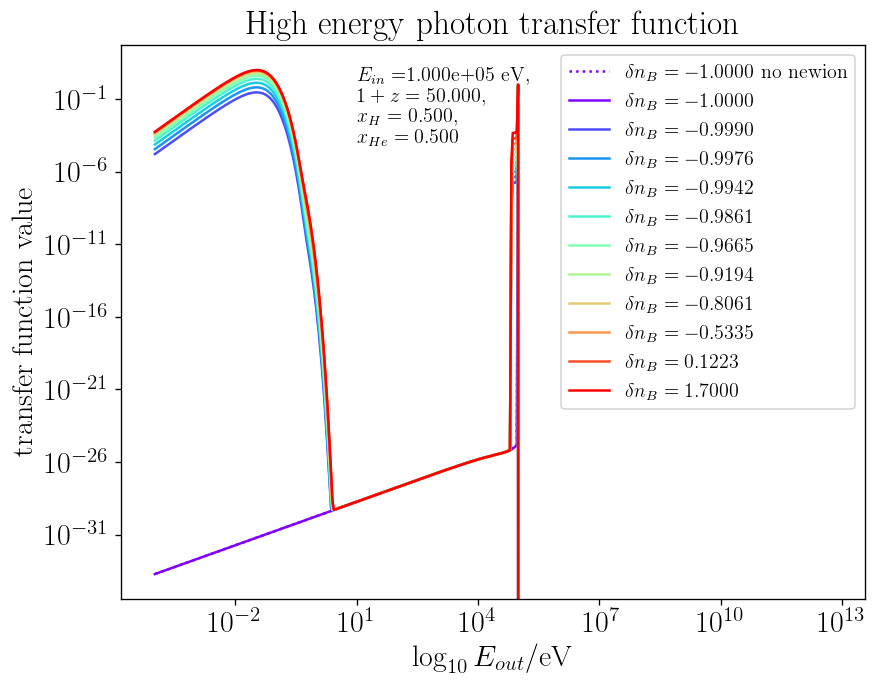

In [11]:
fig, ax = plt.subplots(figsize=(8,6))
cmap = plt.get_cmap('rainbow')

ax.plot(eng, hep_tfs_debug[0], color=cmap(0), label=('$\delta n_{B}=%.4f$'%nhds[i] + ' no newion'), linestyle=':')
for i, hep_tf in enumerate(hep_tfs):
    if i%1 == 0:
        ax.plot(eng, hep_tf, color=cmap(i/(len(hep_tfs)-1)), label='$\delta n_{B}=%.4f$'%nhds[i])
        
ax.set(xscale='log', yscale='log')
ax.set(title='High energy photon transfer function')
ax.set(xlabel='$\log_{10}E_{out}$/eV', ylabel='transfer function value')
ax.text(1e1, 1e-4, '$E_{in}=$%.3e eV,\n$1+z=%.3f$,\n$x_H=%.3f$,\n$x_{He}=%.3f$' % (Ein, z, xH, xHe), fontsize=12)
ax.legend(fontsize=12);

## 2. One ($rs$, $x_{HII}$, $x_{HeII}$, $n_B=0$) point

In [16]:
# single point: low energy or high energy
z = 50 # actually 1+z
#Ein = 1e5 # benchmark: 1e7 or 1e12
xH = 0.5
xHe = 0.5
nhd = -1.

In [17]:
hep_tf_slice = np.zeros((500, 500))
injElow_i = np.searchsorted(abscs['photeng'], 125) + 1

for i, Ein in enumerate(abscs['photeng']):
    if i < injElow_i:
        continue
    with fits.open(fitsfn(z, np.log10(Ein), xH, xHe, nhd)) as fitsf:
        eng = fitsf[1].data['energy'][0]
        hep_tf_slice[i] = Spectrum(eng, fitsf[1].data['photonspectrum'][0,1]/2.0, spec_type='dNdE').N
        #lep_tf[rs_i][Ein_i] = Spectrum(photE, fitsf[1].data['lowengphot'][0,1]/2.0, spec_type='dNdE').N
        #lee_tf[rs_i][Ein_i] = Spectrum(elecE, fitsf[1].data['lowengelec'][0,1]/2.0, spec_type='dNdE').N
        #cmbloss[rs_i][Ein_i] = fitsf[1].data['cmblosstable'][0,1]/2.0
        #hed_tf[rs_i][Ein_i] = fitsf[1].data['highdeposited_grid'][0,:,1]/2.0
        #if Ein_i == nphotE-1:
        #    lowerbound[rs_i] = fitsf[1].data['lowerbound'][0,1]

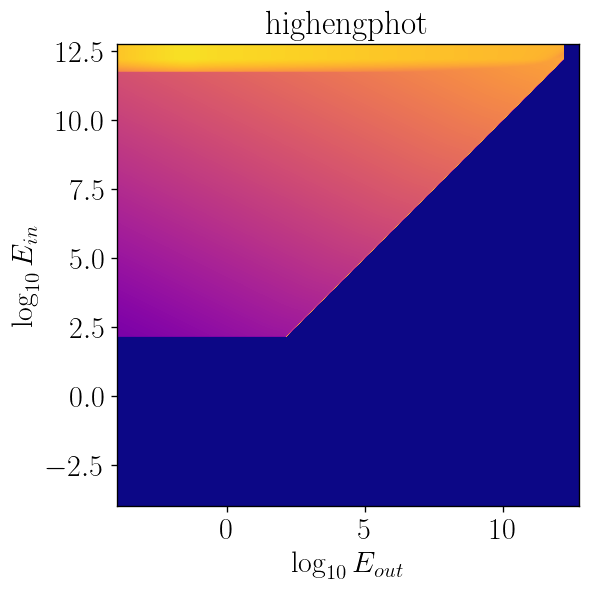

In [21]:
fig, ax = plt.subplots(figsize=(25, 5))

extent = np.log10((abscs['photeng'][0],abscs['photeng'][-1], abscs['photeng'][0], abscs['photeng'][-1]))

ax.imshow(plot_val(hep_tf_slice), vmin=-55, vmax=10, extent=extent, cmap='plasma')
ax.set(xlabel='$\log_{10}E_{out}$', ylabel='$\log_{10}E_{in}$')
ax.set(title='highengphot');

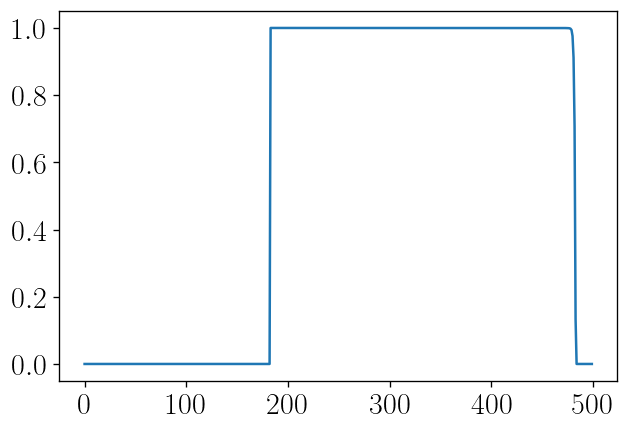

In [23]:
plt.plot(np.diagonal(hep_tf_slice))